# Sleep Staging Prediction - Visualization & Analysis

This notebook generates presentation-ready diagrams for sleep staging prediction evaluation.

**Visualizations included:**
- Confusion Matrix Heatmap
- Per-Class Performance Metrics
- Class Distribution Comparison
- Overall Performance Radar Chart
- Temporal Prediction Analysis

In [11]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    confusion_matrix,
    cohen_kappa_score,
    classification_report
)

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define sleep stage names
STAGE_NAMES = ['Wake', 'Stage 1', 'Stage 2', 'Stage 3', 'REM']
STAGE_COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

## 1. Load Prediction Data

In [12]:
def load_predictions(predictions_dir):
    """
    Load all prediction CSV files.
    
    Args:
        predictions_dir: Directory containing prediction CSV files
        
    Returns:
        DataFrame with all predictions and metadata
    """
    all_data = []
    
    prediction_files = sorted([
        f for f in os.listdir(predictions_dir)
        if f.endswith('_predictions.csv')
    ])
    
    print(f"Loading {len(prediction_files)} prediction files...")
    
    for pred_file in prediction_files:
        pred_path = os.path.join(predictions_dir, pred_file)
        df = pd.read_csv(pred_path)
        
        # Extract subject ID from filename
        subject_id = pred_file.replace('_predictions.csv', '')
        df['SubjectID'] = subject_id
        
        all_data.append(df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total epochs loaded: {len(combined_df)}")
    print(f"Total subjects: {len(prediction_files)}")
    
    return combined_df

# Load data
predictions_dir = "/home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions"
df_predictions = load_predictions(predictions_dir)

# Display sample
print("\nSample predictions:")
df_predictions.head(10)

Loading 66 prediction files...
Total epochs loaded: 35043
Total subjects: 66

Sample predictions:


,Epoch,GroundTruth,Predicted,Confidence_Wake,Confidence_Stage1,Confidence_Stage2,Confidence_Stage3,Confidence_REM,SubjectID
0,0,0,0,0.978909,0.007001,0.006559,0.001428,0.006103,00000396-159547
1,1,0,0,0.986617,0.003713,0.004579,0.000917,0.004173,00000396-159547
2,2,0,0,0.990997,0.003309,0.002884,0.000534,0.002276,00000396-159547
3,3,0,0,0.993131,0.001524,0.002758,0.000437,0.002149,00000396-159547
4,4,0,0,0.994855,0.000923,0.002164,0.000440,0.001619,00000396-159547
5,5,0,0,0.995035,0.000836,0.002112,0.000449,0.001568,00000396-159547
6,6,0,0,0.994360,0.000689,0.002677,0.000606,0.001668,00000396-159547
7,7,0,0,0.995529,0.000580,0.002080,0.000505,0.001307,00000396-159547
8,8,0,0,0.996250,0.000445,0.001744,0.000502,0.001059,00000396-159547
9,9,0,0,0.996371,0.000404,0.001703,0.000524,0.000998,00000396-159547


## 2. Calculate Metrics

In [13]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics.
    """
    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1, 2, 3, 4], zero_division=0
    )
    
    # Macro-averaged metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Weighted-averaged metrics
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'cohen_kappa': kappa
    }
    
    return metrics

# Calculate metrics
y_true = df_predictions['GroundTruth'].values
y_pred = df_predictions['Predicted'].values

metrics = calculate_metrics(y_true, y_pred)

# Display summary
print(f"Overall Accuracy: {metrics['accuracy']*100:.2f}%")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print(f"Macro F1-Score: {metrics['f1_macro']*100:.2f}%")
print(f"Weighted F1-Score: {metrics['f1_weighted']*100:.2f}%")

Overall Accuracy: 21.48%
Cohen's Kappa: 0.0008
Macro F1-Score: 9.72%
Weighted F1-Score: 12.16%


## 3. Visualization 1: Confusion Matrix Heatmap

Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/confusion_matrix.png


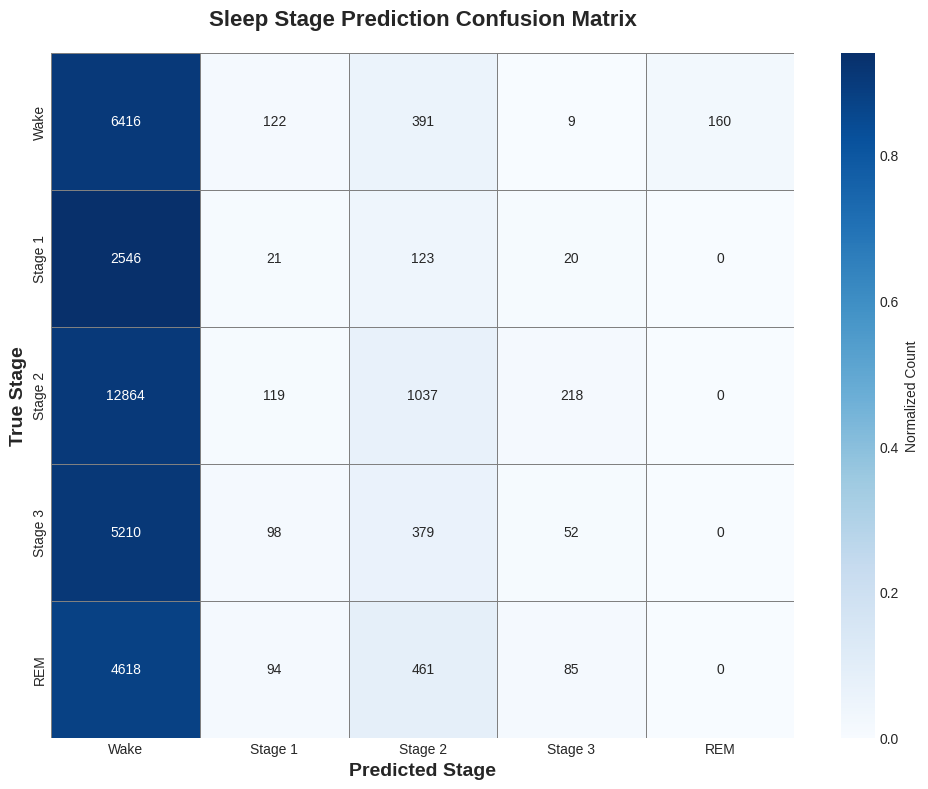

In [14]:
def plot_confusion_matrix(cm, stage_names, save_path=None):
    """
    Create a beautiful confusion matrix heatmap.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=stage_names, yticklabels=stage_names,
                cbar_kws={'label': 'Normalized Count'},
                linewidths=0.5, linecolor='gray', ax=ax)
    
    ax.set_xlabel('Predicted Stage', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Stage', fontsize=14, fontweight='bold')
    ax.set_title('Sleep Stage Prediction Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(
    metrics['confusion_matrix'], 
    STAGE_NAMES,
    save_path=os.path.join(predictions_dir, 'confusion_matrix.png')
)

## 4. Visualization 2: Per-Class Performance Metrics

Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/per_class_metrics.png


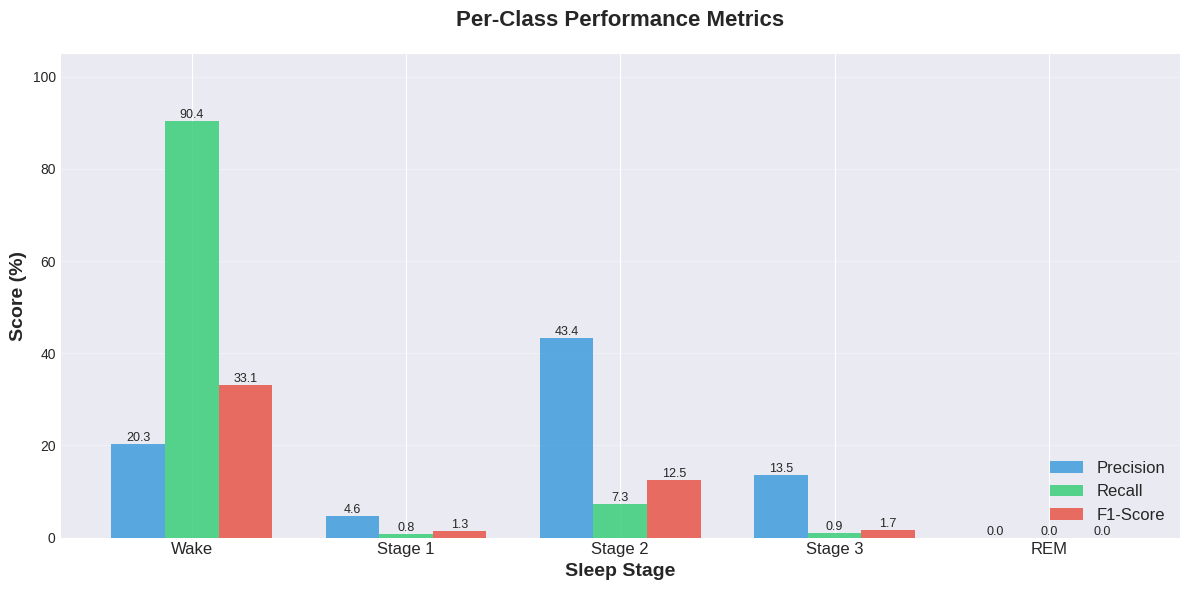

In [15]:
def plot_per_class_metrics(metrics, stage_names, stage_colors, save_path=None):
    """
    Create grouped bar chart for per-class metrics.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(stage_names))
    width = 0.25
    
    # Create bars
    bars1 = ax.bar(x - width, metrics['precision_per_class'] * 100, width, 
                   label='Precision', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x, metrics['recall_per_class'] * 100, width, 
                   label='Recall', color='#2ecc71', alpha=0.8)
    bars3 = ax.bar(x + width, metrics['f1_per_class'] * 100, width, 
                   label='F1-Score', color='#e74c3c', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Sleep Stage', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
    ax.set_title('Per-Class Performance Metrics', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(stage_names, fontsize=12)
    ax.legend(fontsize=12, loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 105)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Plot per-class metrics
plot_per_class_metrics(
    metrics, 
    STAGE_NAMES, 
    STAGE_COLORS,
    save_path=os.path.join(predictions_dir, 'per_class_metrics.png')
)

## 5. Visualization 3: Class Distribution Comparison

Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/class_distribution.png


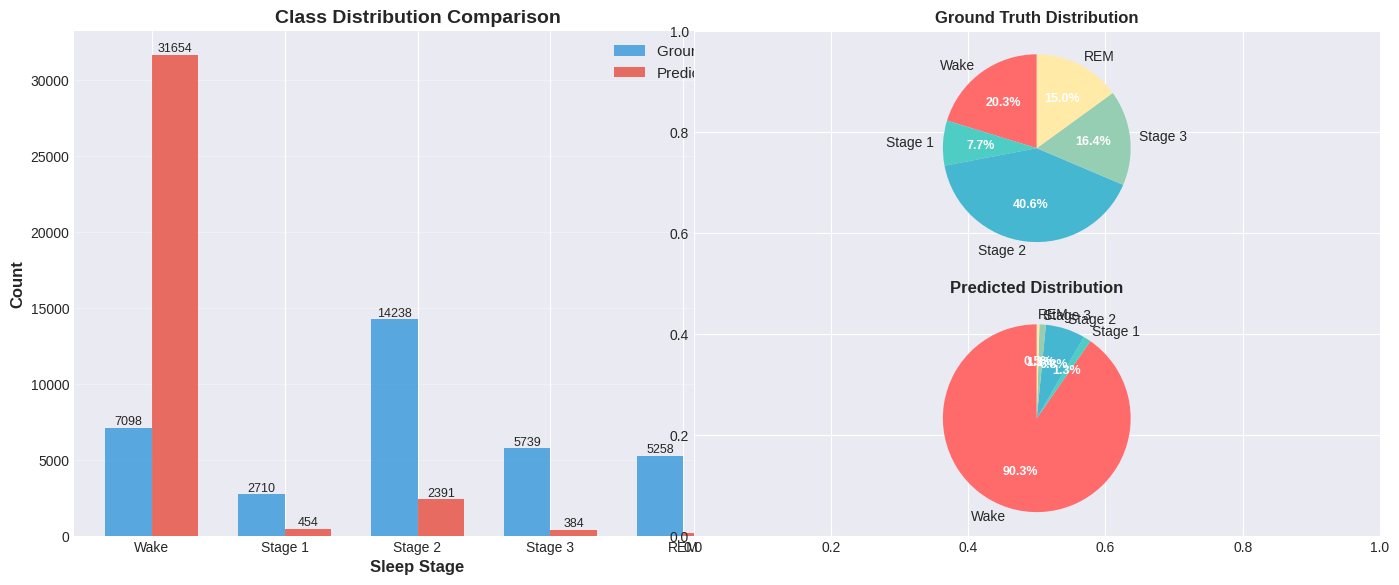

In [16]:
def plot_class_distribution(y_true, y_pred, stage_names, stage_colors, save_path=None):
    """
    Compare ground truth vs predicted class distributions.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Count occurrences
    true_counts = [np.sum(y_true == i) for i in range(5)]
    pred_counts = [np.sum(y_pred == i) for i in range(5)]
    
    # Plot 1: Side-by-side bar chart
    x = np.arange(len(stage_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, true_counts, width, label='Ground Truth', 
                    color='#3498db', alpha=0.8)
    bars2 = ax1.bar(x + width/2, pred_counts, width, label='Predicted', 
                    color='#e74c3c', alpha=0.8)
    
    ax1.set_xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax1.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(stage_names, fontsize=10)
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Pie charts
    true_percentages = [count/sum(true_counts)*100 for count in true_counts]
    pred_percentages = [count/sum(pred_counts)*100 for count in pred_counts]
    
    # Create subplots for pie charts
    ax2_1 = plt.subplot(2, 2, 2)
    ax2_2 = plt.subplot(2, 2, 4)
    
    # Ground truth pie
    wedges1, texts1, autotexts1 = ax2_1.pie(true_counts, labels=stage_names, 
                                             autopct='%1.1f%%', colors=stage_colors,
                                             startangle=90)
    ax2_1.set_title('Ground Truth Distribution', fontsize=12, fontweight='bold')
    
    # Predicted pie
    wedges2, texts2, autotexts2 = ax2_2.pie(pred_counts, labels=stage_names, 
                                             autopct='%1.1f%%', colors=stage_colors,
                                             startangle=90)
    ax2_2.set_title('Predicted Distribution', fontsize=12, fontweight='bold')
    
    # Make percentage text bold
    for autotext in autotexts1 + autotexts2:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Plot class distribution
plot_class_distribution(
    y_true, 
    y_pred, 
    STAGE_NAMES, 
    STAGE_COLORS,
    save_path=os.path.join(predictions_dir, 'class_distribution.png')
)

## 6. Visualization 4: Overall Performance Radar Chart

Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/performance_radar.png


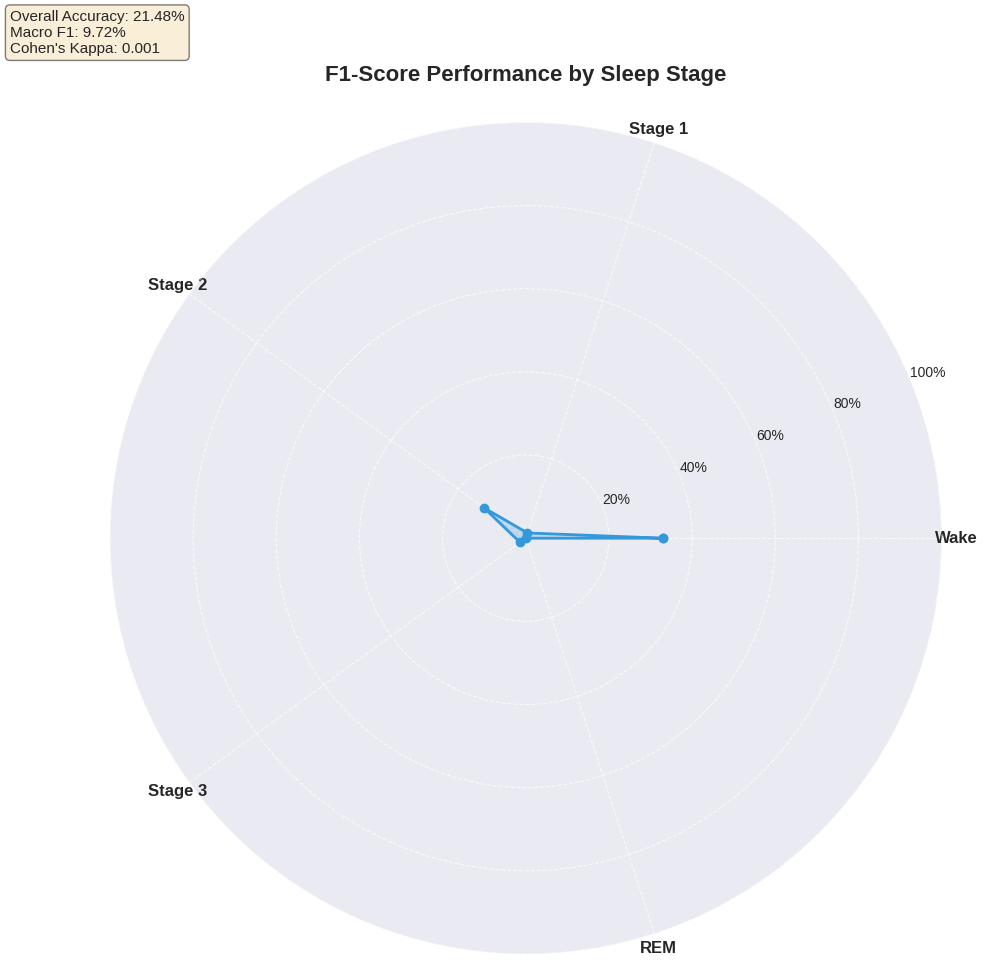

In [17]:
def plot_performance_radar(metrics, stage_names, save_path=None):
    """
    Create radar chart showing F1-scores for each class.
    """
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Prepare data
    categories = stage_names
    values = metrics['f1_per_class'] * 100
    
    # Number of variables
    N = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    values = np.concatenate((values, [values[0]]))  # Complete the circle
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color='#3498db', label='F1-Score')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    
    # Fix axis to go in the right order
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    
    # Set y-axis limits
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
    
    # Add title
    ax.set_title('F1-Score Performance by Sleep Stage', 
                 fontsize=16, fontweight='bold', pad=30)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend with overall metrics
    legend_text = f"Overall Accuracy: {metrics['accuracy']*100:.2f}%\n" + \
                  f"Macro F1: {metrics['f1_macro']*100:.2f}%\n" + \
                  f"Cohen's Kappa: {metrics['cohen_kappa']:.3f}"
    ax.text(0.02, 0.98, legend_text, transform=fig.transFigure, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Plot radar chart
plot_performance_radar(
    metrics, 
    STAGE_NAMES,
    save_path=os.path.join(predictions_dir, 'performance_radar.png')
)

## 7. Visualization 5: Sample Subject Temporal Analysis

Plotting temporal analysis for subject: 00000396-159547
Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/temporal_00000396-159547.png


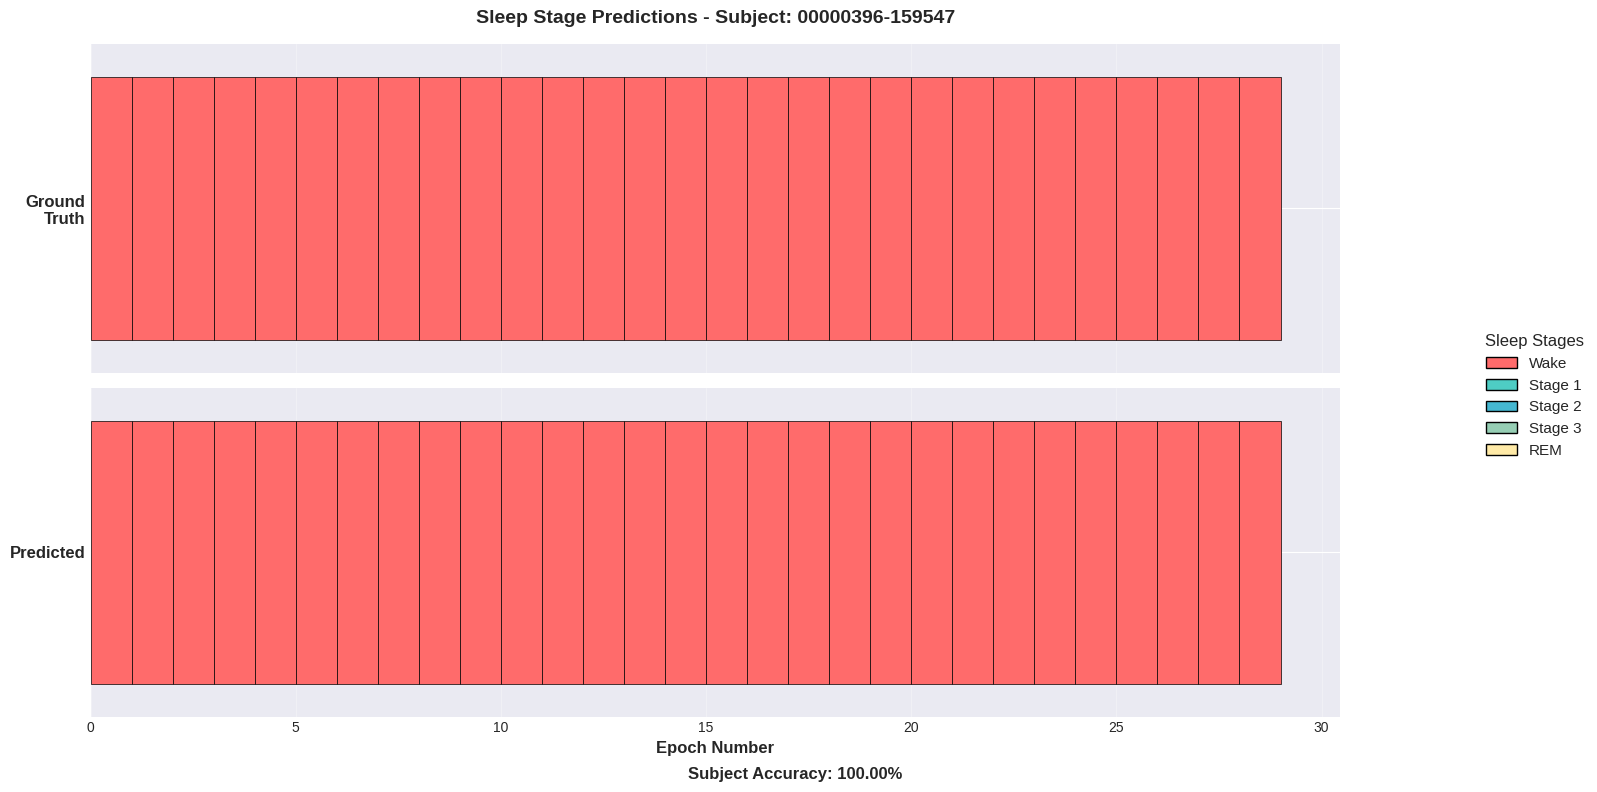

In [18]:
def plot_temporal_predictions(df, subject_id, stage_names, stage_colors, save_path=None):
    """
    Plot temporal sequence of predictions vs ground truth for a subject.
    """
    # Filter data for specific subject
    subject_data = df[df['SubjectID'] == subject_id].copy()
    
    if len(subject_data) == 0:
        print(f"No data found for subject {subject_id}")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
    
    epochs = subject_data['Epoch'].values
    y_true = subject_data['GroundTruth'].values
    y_pred = subject_data['Predicted'].values
    
    # Plot ground truth
    for i in range(len(epochs)):
        ax1.barh(0, 1, left=epochs[i], height=0.8, 
                color=stage_colors[y_true[i]], edgecolor='black', linewidth=0.5)
    
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_yticks([0])
    ax1.set_yticklabels(['Ground\nTruth'], fontsize=12, fontweight='bold')
    ax1.set_title(f'Sleep Stage Predictions - Subject: {subject_id}', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot predictions
    for i in range(len(epochs)):
        ax2.barh(0, 1, left=epochs[i], height=0.8, 
                color=stage_colors[y_pred[i]], edgecolor='black', linewidth=0.5)
    
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_yticks([0])
    ax2.set_yticklabels(['Predicted'], fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch Number', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=stage_colors[i], edgecolor='black', 
                             label=stage_names[i]) for i in range(5)]
    fig.legend(handles=legend_elements, loc='center right', 
              fontsize=11, title='Sleep Stages', title_fontsize=12)
    
    # Calculate accuracy for this subject
    subject_accuracy = np.mean(y_true == y_pred) * 100
    fig.text(0.5, 0.02, f'Subject Accuracy: {subject_accuracy:.2f}%', 
            ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 0.85, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Get first subject for demonstration
sample_subject = df_predictions['SubjectID'].unique()[0]
print(f"Plotting temporal analysis for subject: {sample_subject}")

plot_temporal_predictions(
    df_predictions, 
    sample_subject, 
    STAGE_NAMES, 
    STAGE_COLORS,
    save_path=os.path.join(predictions_dir, f'temporal_{sample_subject}.png')
)

## 8. Visualization 6: Per-Subject Performance Comparison

Saved: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions/per_subject_performance.png


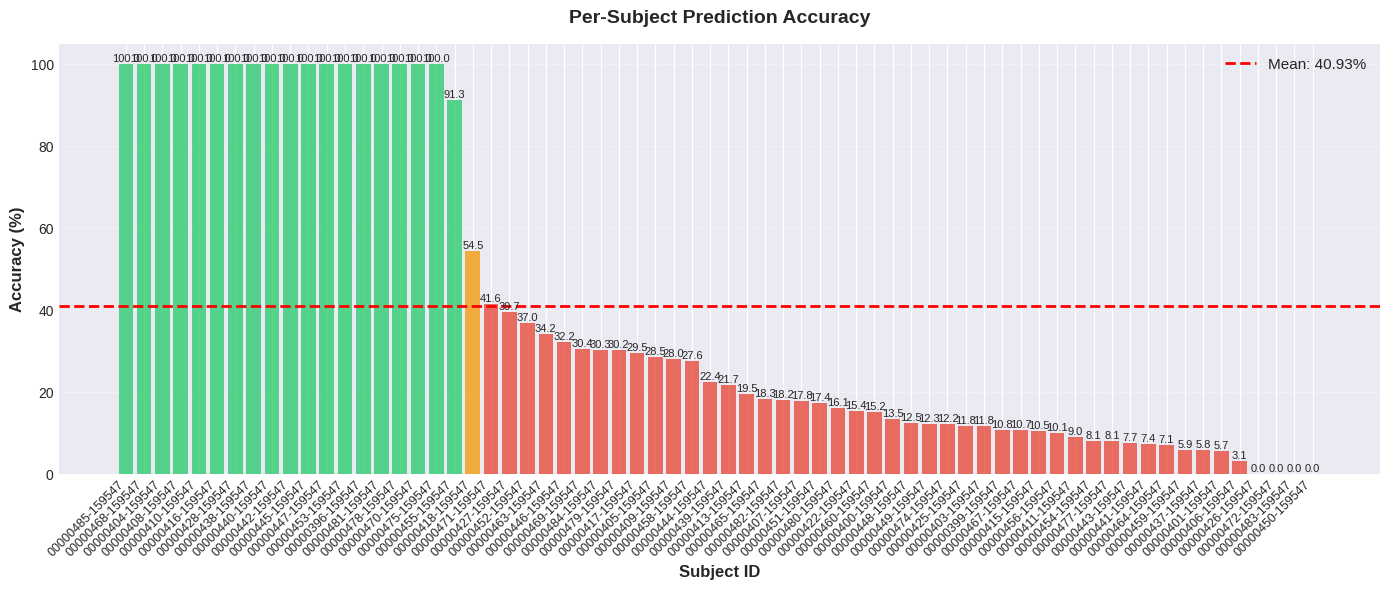


Per-Subject Statistics:
Mean Accuracy: 40.93%
Std Accuracy: 38.70%
Min Accuracy: 0.00%
Max Accuracy: 100.00%


In [19]:
def plot_per_subject_performance(df, save_path=None):
    """
    Compare performance across different subjects.
    """
    # Calculate accuracy per subject
    subject_accuracies = []
    subject_ids = []
    
    for subject_id in df['SubjectID'].unique():
        subject_data = df[df['SubjectID'] == subject_id]
        accuracy = np.mean(subject_data['GroundTruth'] == subject_data['Predicted']) * 100
        subject_accuracies.append(accuracy)
        subject_ids.append(subject_id)
    
    # Sort by accuracy
    sorted_indices = np.argsort(subject_accuracies)[::-1]
    subject_ids = [subject_ids[i] for i in sorted_indices]
    subject_accuracies = [subject_accuracies[i] for i in sorted_indices]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = ['#2ecc71' if acc >= 70 else '#f39c12' if acc >= 50 else '#e74c3c' 
              for acc in subject_accuracies]
    
    bars = ax.bar(range(len(subject_ids)), subject_accuracies, color=colors, alpha=0.8)
    
    # Add mean line
    mean_accuracy = np.mean(subject_accuracies)
    ax.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_accuracy:.2f}%')
    
    ax.set_xlabel('Subject ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Per-Subject Prediction Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(len(subject_ids)))
    ax.set_xticklabels(subject_ids, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 105)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, subject_accuracies)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{acc:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    
    # Print statistics
    print(f"\nPer-Subject Statistics:")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")
    print(f"Std Accuracy: {np.std(subject_accuracies):.2f}%")
    print(f"Min Accuracy: {np.min(subject_accuracies):.2f}%")
    print(f"Max Accuracy: {np.max(subject_accuracies):.2f}%")

# Plot per-subject performance
plot_per_subject_performance(
    df_predictions,
    save_path=os.path.join(predictions_dir, 'per_subject_performance.png')
)

## 9. Summary Report

In [20]:
def generate_summary_report(metrics, df, stage_names):
    """
    Generate comprehensive summary report.
    """
    print("="*70)
    print("SLEEP STAGING PREDICTION - EVALUATION SUMMARY")
    print("="*70)
    
    print(f"\nDataset Information:")
    print(f"  Total Epochs: {len(df):,}")
    print(f"  Total Subjects: {df['SubjectID'].nunique()}")
    
    print(f"\nOverall Performance:")
    print(f"  Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"  Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    
    print(f"\nMacro-Averaged Metrics:")
    print(f"  Precision: {metrics['precision_macro']*100:.2f}%")
    print(f"  Recall: {metrics['recall_macro']*100:.2f}%")
    print(f"  F1-Score: {metrics['f1_macro']*100:.2f}%")
    
    print(f"\nWeighted-Averaged Metrics:")
    print(f"  Precision: {metrics['precision_weighted']*100:.2f}%")
    print(f"  Recall: {metrics['recall_weighted']*100:.2f}%")
    print(f"  F1-Score: {metrics['f1_weighted']*100:.2f}%")
    
    print(f"\nPer-Class Performance:")
    print(f"  {'Stage':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("  " + "-"*60)
    for i, stage_name in enumerate(stage_names):
        print(f"  {stage_name:<12} {metrics['precision_per_class'][i]*100:>10.2f}%  "
              f"{metrics['recall_per_class'][i]*100:>10.2f}%  "
              f"{metrics['f1_per_class'][i]*100:>10.2f}%  "
              f"{metrics['support_per_class'][i]:>10.0f}")
    
    print("\n" + "="*70)
    print("All visualizations have been saved to:", predictions_dir)
    print("="*70)

# Generate summary report
generate_summary_report(metrics, df_predictions, STAGE_NAMES)

SLEEP STAGING PREDICTION - EVALUATION SUMMARY

Dataset Information:
  Total Epochs: 35,043
  Total Subjects: 66

Overall Performance:
  Accuracy: 21.48%
  Cohen's Kappa: 0.0008

Macro-Averaged Metrics:
  Precision: 16.36%
  Recall: 19.87%
  F1-Score: 9.72%

Weighted-Averaged Metrics:
  Precision: 24.30%
  Recall: 21.48%
  F1-Score: 12.16%

Per-Class Performance:
  Stage        Precision    Recall       F1-Score     Support     
  ------------------------------------------------------------
  Wake              20.27%       90.39%       33.11%        7098
  Stage 1            4.63%        0.77%        1.33%        2710
  Stage 2           43.37%        7.28%       12.47%       14238
  Stage 3           13.54%        0.91%        1.70%        5739
  REM                0.00%        0.00%        0.00%        5258

All visualizations have been saved to: /home/nummm/Documents/CEPP/sleepfm-clinical/custom/predictions


## 10. Export All Visualizations

All visualizations have been saved to the predictions directory with high resolution (300 DPI) for presentation use.

**Generated files:**
- `confusion_matrix.png` - Confusion matrix heatmap
- `per_class_metrics.png` - Per-class performance bar chart
- `class_distribution.png` - Class distribution comparison
- `performance_radar.png` - F1-score radar chart
- `temporal_[subject].png` - Temporal prediction visualization
- `per_subject_performance.png` - Per-subject accuracy comparison